In [ ]:
import numpy as np

import pandas as pd
df = pd.read_parquet("./data.parquet")
df

In [2]:
maximums = df.groupby(["variant"]).max().loc[:, "real_tests":].add_prefix("max_")
maximums

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions
variant,,,,,,,,,
7715543794665,294,134,37,849,570,288,321,153,47
125274540936118,180,96,37,570,381,192,156,72,21
129326688897842,408,168,33,1227,840,432,639,318,106
161027838048146,315,165,61,1227,840,432,519,278,106
305649686817315,399,261,129,570,381,192,278,156,64
...,...,...,...,...,...,...,...,...,...
18446559886681298806,435,241,97,822,561,288,418,231,92
18446566087052598706,1076,524,256,1972,1004,512,1972,1004,512
18446579314662138747,204,113,46,570,381,192,184,86,26


In [3]:
squished = pd.read_csv("./squished.csv").set_index("variant").add_suffix("_squished")
squished

,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
variant,,,,,,,
12108445569812518508,12108445569812518508,44,28,16,44,24,12
13295520056715543416,12108445569812518508,48,28,16,40,22,12
849832514006898133,12108445569812518508,44,28,16,44,24,12
2242271814187683694,12108445569812518508,48,28,16,40,22,12
14543158900860426855,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...
12108503680821292064,10400443906235986897,570,381,192,278,156,64
5197127551653372282,10400443906235986897,570,381,192,278,156,64
6911147947297802591,10400443906235986897,570,381,192,278,156,64


In [4]:
out = maximums.join(squished, on="variant").sort_values("max_real_tests")
out

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
variant,,,,,,,,,,,,,,,,
455433835029453866,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
9592099295490535412,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
757967249813600158,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
11534756378514934989,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
4281292345261825678,26,10,4,26,14,8,26,14,8,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198870387126812067,3412,1108,256,7508,3924,2048,7508,3924,2048,7564251811280446802,7508,3924,2048,7508,3924,2048
6836514512422624260,3412,1108,256,7508,3924,2048,7508,3924,2048,17371471886367027712,7508,3924,2048,7508,3924,2048
16782821360216288551,3412,1108,256,7508,3924,2048,7508,3924,2048,15585469538733603667,7508,3924,2048,7508,3924,2048


In [5]:
s = pd.Series(list(range(len(out))))
out = out.set_index(s)
out

,max_real_tests,max_real_downs,max_real_solutions,max_limit_tests,max_limit_downs,max_limit_solutions,max_approx_tests,max_approx_downs,max_approx_solutions,spec_squished,limit_tests_squished,limit_downs_squished,limit_solutions_squished,approx_tests_squished,approx_downs_squished,approx_solutions_squished
0,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
1,20,12,8,20,12,8,20,12,8,455433835029453866,20,12,8,20,12,8
2,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
3,24,14,7,30,21,12,24,13,6,11534756378514934989,30,21,12,24,13,6
4,26,10,4,26,14,8,26,14,8,12108445569812518508,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256065,3412,1108,256,7508,3924,2048,7508,3924,2048,7564251811280446802,7508,3924,2048,7508,3924,2048
256066,3412,1108,256,7508,3924,2048,7508,3924,2048,17371471886367027712,7508,3924,2048,7508,3924,2048
256067,3412,1108,256,7508,3924,2048,7508,3924,2048,15585469538733603667,7508,3924,2048,7508,3924,2048
256068,3412,1108,256,7508,3924,2048,7508,3924,2048,6576328624894864147,7508,3924,2048,7508,3924,2048


<AxesSubplot:>

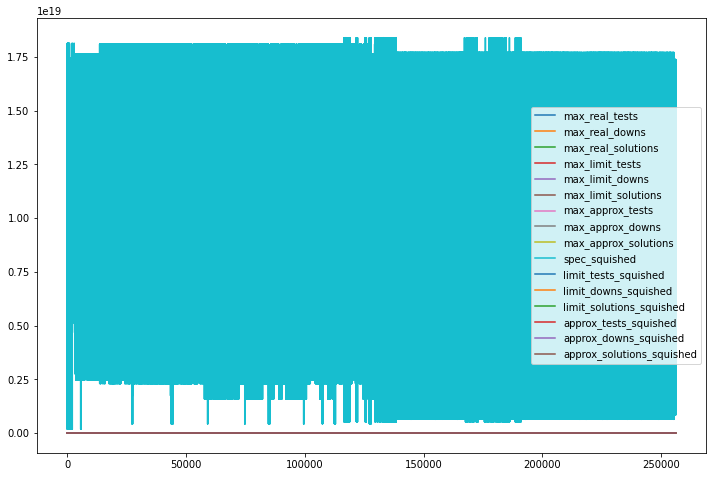

In [6]:
out.plot(figsize=(12,8))

<AxesSubplot:>

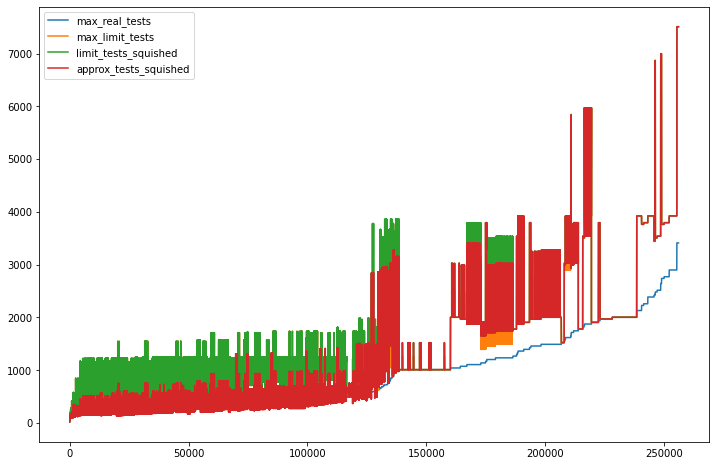

In [7]:
out.loc[:, ["max_real_tests", "max_limit_tests", "limit_tests_squished", "approx_tests_squished"]]\
    .plot(figsize=(12,8))

<AxesSubplot:>

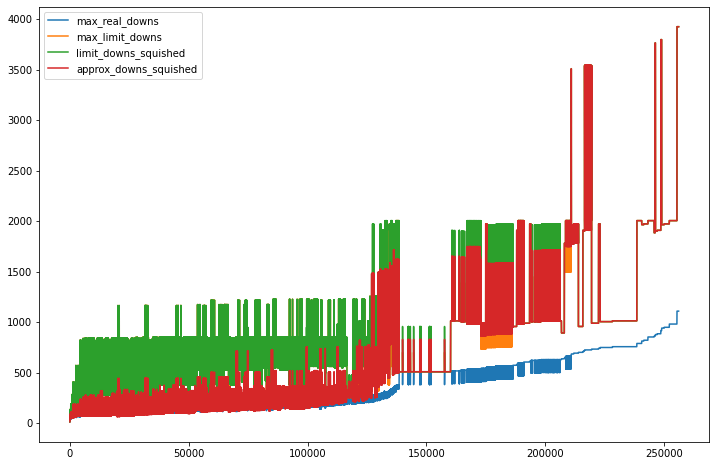

In [8]:
out.loc[:, ["max_real_downs", "max_limit_downs", "limit_downs_squished", "approx_downs_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

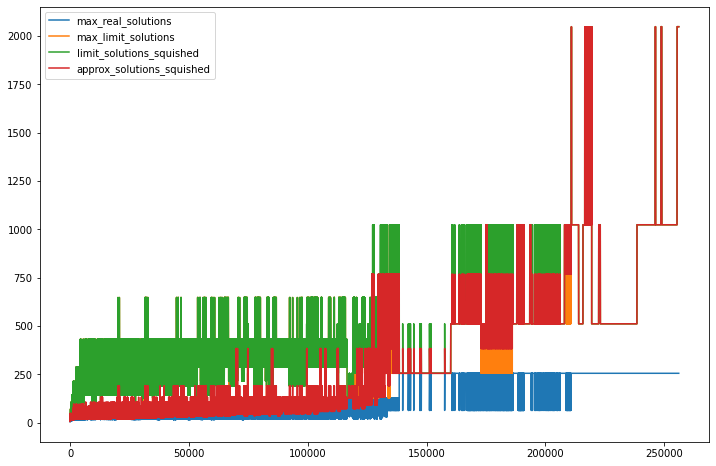

In [9]:
out.loc[:, ["max_real_solutions", "max_limit_solutions", "limit_solutions_squished", "approx_solutions_squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

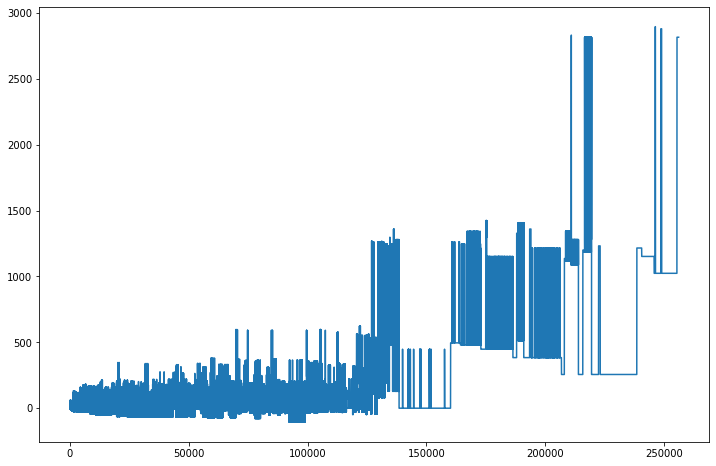

In [10]:
(out["approx_downs_squished"] - out["max_real_downs"]).plot(figsize=(12,8))

In [11]:
opti = pd.read_csv("./optimized.csv", dtype={"spec":str}).loc[:, ["spec", "variant", "real_tests", "real_downs"]].groupby("spec").max()
opti

,variant,real_tests,real_downs
spec,,,
10400443906235986897,10400443906235986897,399,261
10459073594020133314,10459073594020133314,351,189
10812651483495273613,10812651483495273613,1492,628
10815156060926821767,10815156060926821767,54,34
10869151049610600579,10869151049610600579,312,139
...,...,...,...
9111785187471779450,9111785187471779450,180,96
9162266772960708378,9162266772960708378,48,25
9388755696409977685,9388755696409977685,500,252


In [12]:
d = df.loc[:, ["spec", "variant", "real_tests", "real_downs"]].groupby("variant").max()
d

,spec,real_tests,real_downs
variant,,,
7715543794665,8493833601498125635,294,134
125274540936118,2466958442878155789,180,96
129326688897842,17636275641406486134,408,168
161027838048146,18086510989695827449,315,165
305649686817315,10400443906235986897,399,261
...,...,...,...
18446559886681298806,1576518683128211990,435,241
18446566087052598706,11949711655386031310,1076,524
18446579314662138747,13539968757966552730,204,113


In [13]:
d = d.groupby("spec").agg(["min", "max", "mean"]).sort_values(("real_tests", "min"))
d

real_tests                    real_downs                 
                            min   max         mean        min  max        mean
spec                                                                          
455433835029453866           20    20    20.000000         12   12   12.000000
11534756378514934989         24    39    30.000000         14   19   16.000000
12108445569812518508         26    36    30.000000         10   16   12.666667
4368343078470841610          27    27    27.000000         17   17   17.000000
9162266772960708378          45    75    60.500000         24   34   29.166667
...                         ...   ...          ...        ...  ...         ...
636722905832346483         1012  2900  1686.438095        508  980  676.609524
3716462905761986592        1012  2004  1250.933333        508  756  567.733333
5229457540002071285        1012  1012  1012.000000        508  508  508.000000
7736099696248344852        1012  2900  1506.933333        508  980  631.733333
2585307525144518131        1012  2900  1476.761905        508  980  624.190476

[100 rows x 6 columns]

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='spec'>

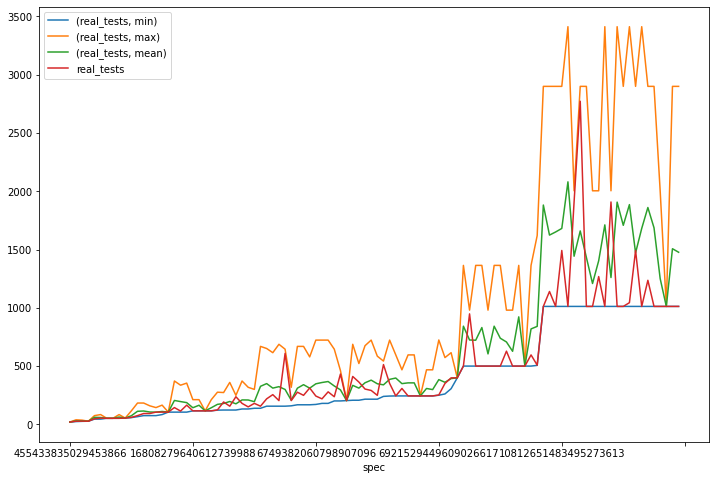

In [14]:
d.loc[:, ["real_tests"]].join(opti.loc[:, ["real_tests"]], on="spec", rsuffix="opti").plot(figsize=(12,8))

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='spec'>

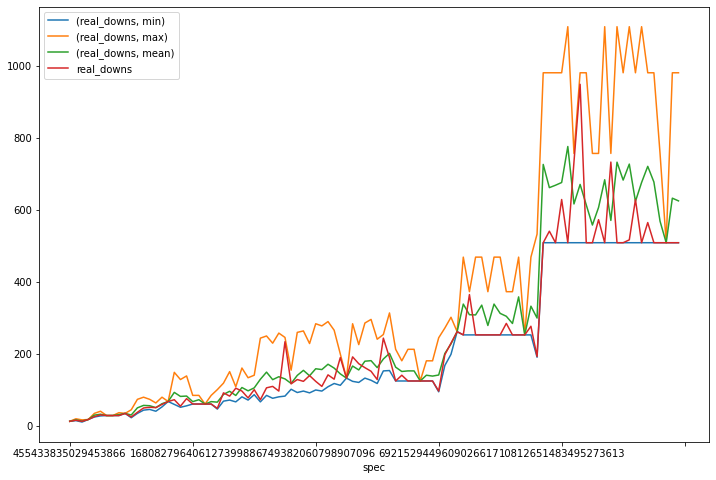

In [15]:
d.loc[:, ["real_downs"]].join(opti.loc[:, ["real_downs"]], on="spec", rsuffix="opti").plot(figsize=(12,8))
